In [1]:
# install LightAutoML
!pip install -U lightautoml

     |████████████████████████████████| 262 kB 5.3 MB/s 
     |████████████████████████████████| 204 kB 60.7 MB/s 
     |████████████████████████████████| 24.1 MB 2.8 kB/s 
     |████████████████████████████████| 1.2 MB 54.6 MB/s 
     |████████████████████████████████| 804.1 MB 2.2 kB/s 
     |████████████████████████████████| 98 kB 7.6 MB/s 
     |████████████████████████████████| 232 kB 60.4 MB/s 
     |████████████████████████████████| 420 kB 50.8 MB/s 
     |████████████████████████████████| 67.4 MB 26 kB/s 
     |████████████████████████████████| 302 kB 59.9 MB/s 
     |████████████████████████████████| 2.8 MB 43.5 MB/s 
     |████████████████████████████████| 37.1 MB 51 kB/s 
     |████████████████████████████████| 2.8 MB 35.6 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 895 kB 51.5 MB/s 
     |████████████████████████████████| 3.3 MB 55.0 MB/s 
     |████████████████████████████████| 636 kB 52.4 MB/s 
     |██████████████

In [1]:
# install rdkti
!pip install kora -q
import kora.install.rdkit

     |████████████████████████████████| 57 kB 2.5 MB/s 
     |████████████████████████████████| 56 kB 3.3 MB/s 


In [2]:
# install mordred
!pip install mordred

     |████████████████████████████████| 128 kB 4.1 MB/s 
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176723 sha256=22ea8e36c680ceb629b818de1964a42723b34636292de2505a996cb87c5a74c0
  Stored in directory: /root/.cache/pip/wheels/02/c0/2e/e7e3d63b431777712ebc128bc4deb9ac5cb19afc7c1ea341ec
Successfully built mordred


In [4]:
# for lightAutoML
!pip install numpy==1.21.2

     |████████████████████████████████| 15.7 MB 193 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.8.1 which is incompatible.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Before run next cell, It needs "Runtime restart"

In [3]:
# Python libraries
import random
import os
import sys
import time
import copy
import zipfile
import argparse
import warnings; warnings.filterwarnings("ignore")

# DS libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# # Modeling libraries
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from torch.autograd import Variable

# Feature extraction for SMILES libraries (rdkit, mordred)
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from mordred import Calculator, descriptors

# # LightAutoML presets, task and report generation
# from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
# from lightautoml.tasks import Task
# from lightautoml.report.report_deco import ReportDeco

In [4]:
# Setup constants
MY_PATH = '/content/drive/MyDrive/Colab_Notebooks/dacon/'
DATA_DIR = MY_PATH + 'data/'
SUBMISSION_DIR = MY_PATH + 'submission/'
CLEANED_DIR = MY_PATH + 'cleaned/'
MODEL_DIR = MY_PATH + 'model/'

N_THREADS = 4
N_FOLDS = 10
RANDOM_STATE = 42
TEST_SIZE = 0.1
TIMEOUT = 3*3600
TARGET_NAME = 'ST1'

In [5]:
# Fix random seed for reproducibility
np.random.seed(RANDOM_STATE)
# torch.set_num_threads(N_THREADS)

## 02. Data Pre-processing

In [6]:
# Extract datasets from zip
my_zip = zipfile.ZipFile(DATA_DIR + "Samsung AI Challenge for Scientific Discovery_data.zip")
if not (os.path.isdir('./dataset')):
  os.makedirs(os.path.join('dataset'))
my_zip.extractall('dataset')
my_zip.close()

In [7]:
# Load datasets
train_original = pd.read_csv('dataset/train.csv')
dev = pd.read_csv('dataset/dev.csv')
test = pd.read_csv('dataset/test.csv')

submission = pd.read_csv('dataset/sample_submission.csv')

In [6]:
# Copy train set for preprocessing
# train = train_original # pd.concat([train_original, dev], axis=0)
train = pd.concat([train_original, dev], axis=0, ignore_index=True)

train_original.shape, train.shape, dev.shape, test.shape

((30274, 4), (30345, 4), (71, 4), (602, 2))

In [7]:
# Create target label
train[TARGET_NAME] = train['S1_energy(eV)'] - train['T1_energy(eV)']
train

,uid,SMILES,S1_energy(eV),T1_energy(eV),ST1
0,train_0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,4.6747,3.3809,1.2938
1,train_1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...,3.6617,3.4585,0.2032
2,train_2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,3.6420,3.1787,0.4633
3,train_3,OC(CNC1CC1)CN1CCc2sccc2C1,4.8901,3.7847,1.1054
4,train_4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,6.4967,6.2724,0.2243
...,...,...,...,...,...
30340,dev_66,N#Cc1cc(-c2ccc(N3c4ccccc4Oc4ccccc43)cc2)c(-c2c...,2.1939,2.1846,0.0093
30341,dev_67,CC1(C)c2ccccc2N(c2ccc(-c3nc4ccc(N5c6ccccc6C(C)...,2.3537,2.3371,0.0166
30342,dev_68,Cc1cc(-n2c3ccc(C(C)(C)C)cc3c3cc(C(C)(C)C)ccc32...,2.1364,2.1260,0.0104
30343,dev_69,Cc1cc(-n2c3ccccc3c3ccccc32)cc(C)c1B1c2ccccc2B(...,2.2650,2.2511,0.0139


In [8]:
calc = Calculator(descriptors, ignore_3D=False)
len(calc.descriptors)

1826

In [ ]:
# Feature extract & save csv files
for i in range(6):
  x_train = calc.pandas([Chem.MolFromSmiles(x) for x in train['SMILES'][i*5000:(i+1)*5000]])
  x_train.to_csv(CLEANED_DIR + f'train_mordred_{i+1}.csv', index=False)
  del x_train # due to RAM memory

x_train = calc.pandas([Chem.MolFromSmiles(x) for x in train['SMILES'][30000:]])
x_train.to_csv(CLEANED_DIR + 'train_mordred_7.csv', index=False)
del x_train_1

In [38]:
train_df = pd.DataFrame()
for i in range(7):
  train_df = train_df.append(pd.read_csv(CLEANED_DIR + f'train_mordred_{i+1}.csv'), ignore_index=True)

train_df.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VE3_A,VR1_A,VR2_A,VR3_A,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0dv,ATS1dv,ATS2dv,ATS3dv,ATS4dv,...,JGI7,JGI8,JGI9,JGI10,JGT10,Diameter,Radius,TopoShapeIndex,PetitjeanIndex,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,21.327242,18.946449,0,0,35.934633,2.483367,4.840914,35.934633,1.283380,4.252780,4.085659,0.145916,2.437102,404.207862,14.435995,7.03155,10,10,53,28,0,0,7,25,0,21,3,4,0,0,0,0,0,0,0,408.000000,405.000000,591.000000,619.000000,663.000000,...,0.014614,0.011464,0.008672,0.007291,0.450829,13,7,0.857143,0.461538,359.9622898227071,5.90689,30.0,4.976734,5.843544,6.734592,7.619233,8.515392,9.405825,10.304108,11.197763,12.097490,134.694680,4.110874,0.00000,5.433722,3.044522,6.951772,5.351858,8.560444,7.423568,10.218335,79.095096,383.184506,7.229896,2093,45,144.0,172.0,10.1111,6.388889
1,33.336126,24.702912,0,0,55.395759,2.572069,4.981325,55.395759,1.318947,4.683004,4.878251,0.116149,3.019871,1854.530455,44.155487,8.96047,29,29,71,42,0,0,9,29,0,33,4,3,1,0,0,1,0,0,1,546.049383,606.777778,847.666667,872.111111,879.333333,...,0.013405,0.010414,0.008453,0.006305,0.416241,19,10,0.9,0.473684,515.2161491820268,6.55459,47.0,5.442418,6.322565,7.230563,8.133587,9.050524,9.965382,10.888688,11.811243,12.739506,170.584477,4.553877,0.00000,5.905362,3.044522,7.450661,5.533389,9.083302,7.727094,10.764583,96.062791,596.164889,8.396689,6192,73,230.0,278.0,12.7778,9.138889
2,20.115229,15.738321,0,0,33.359318,2.367705,4.685218,33.359318,1.283051,4.176757,4.487762,0.172606,2.456866,219.015229,8.423663,6.34465,11,11,49,26,0,0,7,23,0,19,3,3,1,0,0,0,0,0,0,346.444444,338.666667,437.666667,364.666667,374.000000,...,0.012878,0.012714,0.005550,0.004820,0.430307,16,8,1,0.5,337.72557584555796,5.80735,28.0,4.890349,5.713733,6.569481,7.409136,8.267962,9.114820,9.974831,10.825820,11.686366,128.452499,4.043051,0.00000,5.342334,2.397895,6.818924,4.595120,8.371242,6.580639,9.963500,74.112706,373.146013,7.615225,1965,36,132.0,151.0,8.38889,5.750000
3,13.503979,11.269951,0,2,22.542166,2.371355,4.656980,22.542166,1.326010,3.814420,3.589034,0.211120,1.808511,129.053195,7.591364,5.39085,5,5,37,17,0,0,4,20,0,13,2,1,1,0,0,0,0,0,0,162.444444,154.666667,187.000000,171.666667,143.333333,...,0.009410,0.006457,0.007760,0.000000,0.395767,10,5,1,0.5,229.45474474042223,5.24793,19.0,4.510860,5.342334,6.200509,7.044905,7.904335,8.753529,9.613068,10.464731,11.324413,107.158684,3.663562,1.94591,4.962845,3.931826,6.440947,5.777652,8.000685,7.557473,9.604340,68.885239,252.129634,6.814314,582,20,90.0,104.0,4.30556,3.694444
4,14.557282,13.387854,0,1,23.659532,2.405094,4.810189,23.659532,1.182977,3.874846,3.567373,0.178369,1.964977,166.842607,8.342130,5.8102,0,0,46,20,0,0,6,26,0,14,1,2,0,0,3,0,0,0,3,314.000000,226.000000,365.000000,233.000000,225.000000,...,0.019184,0.011770,0.007812,0.000000,0.523067,9,5,0.8,0.444444,285.12368449612643,5.32193,20.0,4.553877,5.342334,6.220590,7.044905,7.930566,8.770439,9.656371,10.505314,11.390181,111.414578,3.713572,0.00000,5.003946,0.000000,6.499787,0.000000,8.097122,0.000000,9.748645,53.063072,297.191564,6.460686,835,27,94.0,104.0,8.23611,4.666667


In [39]:
print(train_df.shape)
print(train.shape)

(30345, 1826)
(30345, 5)


In [45]:
train = pd.concat([train, train_df], axis=1)
train

,uid,SMILES,S1_energy(eV),T1_energy(eV),ST1,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VE3_A,VR1_A,VR2_A,VR3_A,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,...,JGI7,JGI8,JGI9,JGI10,JGT10,Diameter,Radius,TopoShapeIndex,PetitjeanIndex,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,train_0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,4.6747,3.3809,1.2938,21.327242,18.946449,0,0,35.934633,2.483367,4.840914,35.934633,1.283380,4.252780,4.085659,0.145916,2.437102,404.207862,14.435995,7.03155,10,10,53,28,0,0,7,25,0,21,3,4,0,0,0,0,0,0,0,...,0.014614,0.011464,0.008672,0.007291,0.450829,13,7,0.857143,0.461538,359.9622898227071,5.90689,30.0,4.976734,5.843544,6.734592,7.619233,8.515392,9.405825,10.304108,11.197763,12.097490,134.694680,4.110874,0.00000,5.433722,3.044522,6.951772,5.351858,8.560444,7.423568,10.218335,79.095096,383.184506,7.229896,2093,45,144.0,172.0,10.1111,6.388889
1,train_1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...,3.6617,3.4585,0.2032,33.336126,24.702912,0,0,55.395759,2.572069,4.981325,55.395759,1.318947,4.683004,4.878251,0.116149,3.019871,1854.530455,44.155487,8.96047,29,29,71,42,0,0,9,29,0,33,4,3,1,0,0,1,0,0,1,...,0.013405,0.010414,0.008453,0.006305,0.416241,19,10,0.9,0.473684,515.2161491820268,6.55459,47.0,5.442418,6.322565,7.230563,8.133587,9.050524,9.965382,10.888688,11.811243,12.739506,170.584477,4.553877,0.00000,5.905362,3.044522,7.450661,5.533389,9.083302,7.727094,10.764583,96.062791,596.164889,8.396689,6192,73,230.0,278.0,12.7778,9.138889
2,train_2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,3.6420,3.1787,0.4633,20.115229,15.738321,0,0,33.359318,2.367705,4.685218,33.359318,1.283051,4.176757,4.487762,0.172606,2.456866,219.015229,8.423663,6.34465,11,11,49,26,0,0,7,23,0,19,3,3,1,0,0,0,0,0,0,...,0.012878,0.012714,0.005550,0.004820,0.430307,16,8,1,0.5,337.72557584555796,5.80735,28.0,4.890349,5.713733,6.569481,7.409136,8.267962,9.114820,9.974831,10.825820,11.686366,128.452499,4.043051,0.00000,5.342334,2.397895,6.818924,4.595120,8.371242,6.580639,9.963500,74.112706,373.146013,7.615225,1965,36,132.0,151.0,8.38889,5.750000
3,train_3,OC(CNC1CC1)CN1CCc2sccc2C1,4.8901,3.7847,1.1054,13.503979,11.269951,0,2,22.542166,2.371355,4.656980,22.542166,1.326010,3.814420,3.589034,0.211120,1.808511,129.053195,7.591364,5.39085,5,5,37,17,0,0,4,20,0,13,2,1,1,0,0,0,0,0,0,...,0.009410,0.006457,0.007760,0.000000,0.395767,10,5,1,0.5,229.45474474042223,5.24793,19.0,4.510860,5.342334,6.200509,7.044905,7.904335,8.753529,9.613068,10.464731,11.324413,107.158684,3.663562,1.94591,4.962845,3.931826,6.440947,5.777652,8.000685,7.557473,9.604340,68.885239,252.129634,6.814314,582,20,90.0,104.0,4.30556,3.694444
4,train_4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,6.4967,6.2724,0.2243,14.557282,13.387854,0,1,23.659532,2.405094,4.810189,23.659532,1.182977,3.874846,3.567373,0.178369,1.964977,166.842607,8.342130,5.8102,0,0,46,20,0,0,6,26,0,14,1,2,0,0,3,0,0,0,3,...,0.019184,0.011770,0.007812,0.000000,0.523067,9,5,0.8,0.444444,285.12368449612643,5.32193,20.0,4.553877,5.342334,6.220590,7.044905,7.930566,8.770439,9.656371,10.505314,11.390181,111.414578,3.713572,0.00000,5.003946,0.000000,6.499787,0.000000,8.097122,0.000000,9.748645,53.063072,297.191564,6.460686,835,27,94.0,104.0,8.23611,4.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30340,dev_66,N#Cc1cc(-c2ccc(N3c4ccccc4Oc4ccccc43)cc2)c(-c2c...,2.1939,2.1846,0.0093,40.446032,25.963022,0,0,69.152650,2.522629,5.045258,69.152650,1.383053,4.876634,6.475212,0.129504,3.477419,506.485363,10.129

In [47]:
train.to_csv(CLEANED_DIR+"Train_mordred_concat.csv", index=False)

In [6]:
train = pd.read_csv(CLEANED_DIR + "Train_mordred_concat.csv")
# train_df = train.copy()

In [19]:
def train_float(x):
  try:
    x = float(x)
  except ValueError:
    x = np.nan
  return x

temp2 = train.dtypes == 'object'
object_columns = list(temp2[temp2 == True].index)
object_columns.remove('uid');object_columns.remove('SMILES')

for column_name in object_columns:
  train[column_name] = train[column_name].apply(train_float)

In [20]:
drop_columns = list(train.isnull().sum()[train.isnull().sum() > 1000].index)
train = train.drop(drop_columns, axis=1)

In [21]:
# Drop columns with zero sum
temp = train.iloc[:, :].sum() == 0
zerosum_columns = list(temp[temp == True].index)

In [22]:
train = train.drop(zerosum_columns, axis=1)

In [23]:
# train = train_df.fillna(train_df.mean())
print(train.isnull().sum().sum())

35738


In [24]:
train['Lipinski'] = train['Lipinski'].astype(int)
train['GhoseFilter'] = train['GhoseFilter'].astype(int)

In [13]:
# Create bin to startify split
min = np.amin(train[TARGET_NAME])
max = np.amax(train[TARGET_NAME])

bins     = np.linspace(start=min, stop=max, num=5)
y_binned = np.digitize(train[TARGET_NAME], bins, right=True)

# train, test split
tr_data, te_data = train_test_split(train, 
                                    test_size=TEST_SIZE, 
                                    stratify=y_binned, 
                                    random_state=RANDOM_STATE)

print('Data splitted. Parts sizes: tr_data = {}, te_data = {}'.format(tr_data.shape, te_data.shape))

Data splitted. Parts sizes: tr_data = (27310, 1831), te_data = (3035, 1831)


In [14]:
# Setput task
task = Task('reg',)

In [15]:
# Setup roles
roles = {'target': TARGET_NAME,
         'drop': ['uid', 'SMILES', 'T1_energy(eV)', 'S1_energy(eV)']
         }

In [16]:
lgb_params = {
    'metric': 'RMSE',
    'lambda_l1': 1e-07, 
    'lambda_l2': 2e-07, 
    'num_leaves': 42, 
    'feature_fraction': 0.55, 
    'bagging_fraction': 0.9, 
    'bagging_freq': 3, 
    'min_child_samples': 19,
    'num_threads': 4
}

cb_params = {
    'num_trees': 7000, 
    'od_wait': 1200, 
    'learning_rate': 0.02, 
    'l2_leaf_reg': 64, 
    'subsample': 0.83, 
    'random_strength': 17.17, 
    'max_depth': 6, 
    'min_data_in_leaf': 10, 
    'leaf_estimation_iterations': 3,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'bootstrap_type': 'Bernoulli',
    'leaf_estimation_method': 'Newton',
    'random_seed': 42,
    "thread_count": 4
}

In [17]:
print(train.shape)

(30345, 1831)


In [ ]:
# t = []
# for n in list(train['mZagreb1'].unique()):
#   if type(n) == str:
#     t.append(n)
# t
# # divide by zero encountered in log (VR3_A/VR3)
# # missing intrinsic state for ['C'] (ATS0s/Props)
# # invalid value encountered in double_scalars (TopoShapeIndex)
# # unknown atom type (Vabc)
# # divide by zero encountered in power (mZagreb1)

In [195]:
%%time 

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params = {'use_algos': [['lgb', 'cb']]}, # LGBM and CatBoost algos only
                       lgb_params = {'default_params': lgb_params, 'freeze_defaults': True}, # LGBM params
                       cb_params = {'default_params': cb_params, 'freeze_defaults': True}, # CatBoost params
                       verbose = 2 # Available values: 0,1,2,3 (from less detailed to more)
                      )

RD = ReportDeco(output_path = 'tabularAutoML_model_report')
automl_rd = RD(automl)

oof_pred = automl_rd.fit_predict(tr_data, roles = roles)

Start automl preset with listed constraints:
- time: 10800 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (27310, 541)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 10742.854734420776 secs
Start fitting Selector_LightGBM ...

===== Start working with fold 0 for Selector_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.071977
[200]	valid's l2: 0.0685703
[300]	valid's l2: 0.0675414
[400]	valid's l2: 0.0668487
[500]	valid's l2: 0.0663554
[600]	valid's l2: 0.0660446
[700]	valid's l2: 0.0658613
[800]	valid's l2: 0.0656919
[900]	valid's l2: 0.0656235
[1000]	valid's l2: 0.065425
[1100]	valid's l2: 0.0653545
[1200]	valid's l2: 0.0652233
[1300]	valid's l2: 0.0651068
[1400]	valid's l2: 0.0649731
[1500]	valid's l2: 0.0648724
[1600]	valid's l2: 0.0648471
[1700]	valid's l2: 0.0647619
[1800]	valid's l2: 0.0646556
[1900]	valid's l2: 0.0646094
[2000]	valid's l2: 0.0645863
[2100]	valid's l2: 

Model Lvl_0_Pipe_0_Mod_1_CatBoost failed during ml_algo.fit_predict call.

catboost/private/libs/options/catboost_options.cpp:566: Newton leaves estimation method is not supoprted for MAE loss function


Time left 7056.9273290634155

Automl preset training completed in 3743.08 seconds.
CPU times: user 2h 32s, sys: 19.9 s, total: 2h 51s
Wall time: 1h 2min 30s


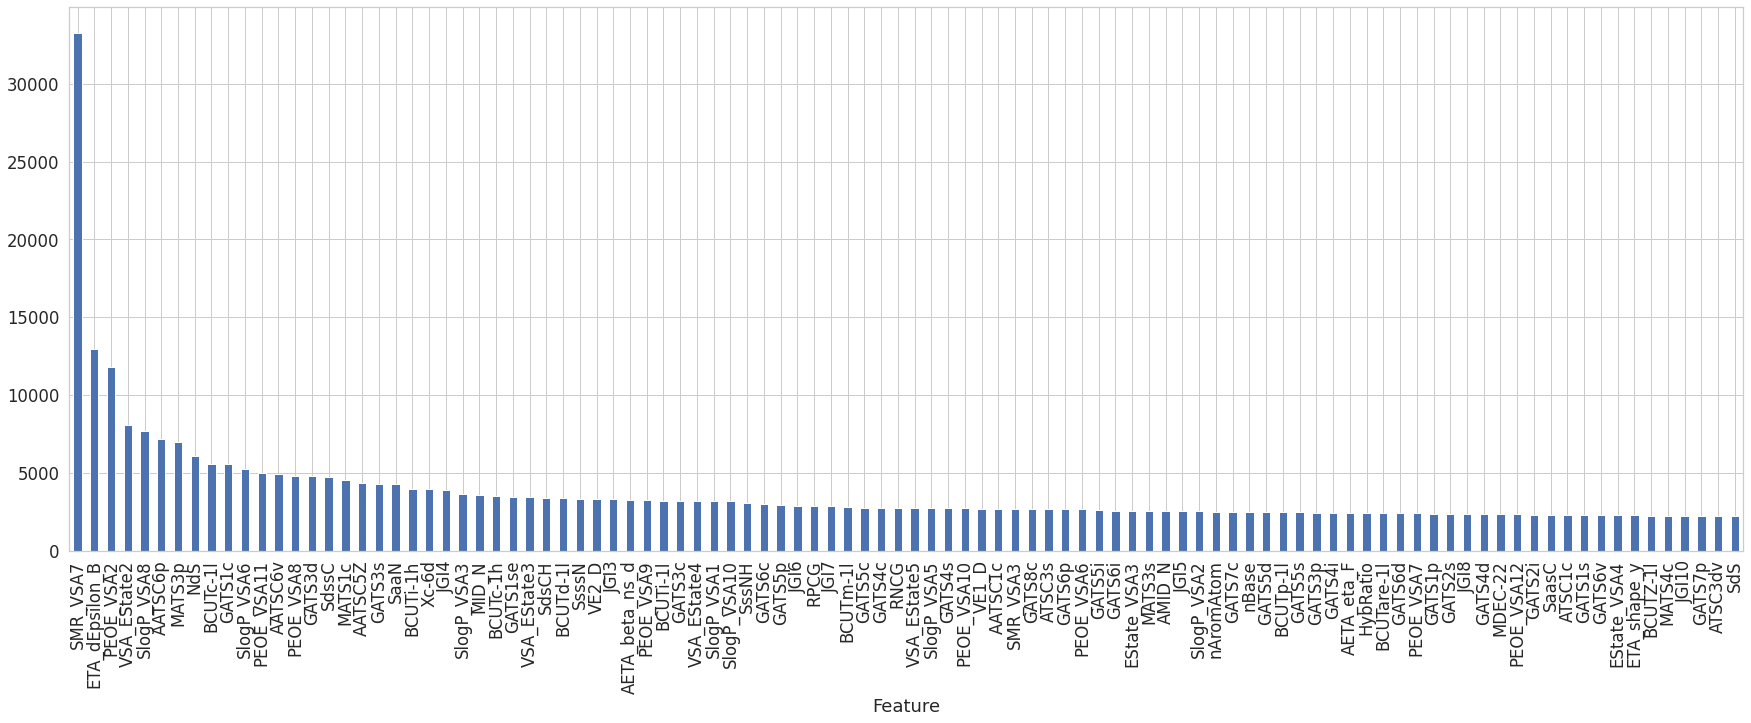

In [171]:
# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'][:100].plot.bar(figsize = (30, 10), grid = True)

In [ ]:
fast_fi

In [172]:
fast_fi.to_csv(MY_PATH + "feature_importance_mordred.csv", index=False)

Evaluation

In [196]:
# test dataset
%%time

te_pred = automl_rd.predict(te_data)
print('Prediction for te_data:\n{}\nShape = {}'
              .format(te_pred, te_data.shape))

Prediction for te_data:
array([[0.974473  ],
       [1.0419648 ],
       [0.8923758 ],
       ...,
       [1.1800491 ],
       [0.23806807],
       [1.044014  ]], dtype=float32)
Shape = (3035, 541)
CPU times: user 16.3 s, sys: 260 ms, total: 16.6 s
Wall time: 10.4 s


In [197]:
print('HOLDOUT score: {}'.format(mean_absolute_error(te_data[TARGET_NAME].values, te_pred.data[:, 0])))
# 0.1744587669620011 
# 0.1754907920923382
# 

HOLDOUT score: 0.17590378536634035


Retrain

In [26]:
# Retrain model
%%time 

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params = {'use_algos': [['lgb', 'cb']]}, # LGBM and CatBoost algos only
                       lgb_params = {'default_params': lgb_params, 'freeze_defaults': True}, # LGBM params
                       cb_params = {'default_params': cb_params, 'freeze_defaults': True}, # CatBoost params
                       verbose = 1 # Available values: 0,1,2,3 (from less detailed to more)
                      )

oof_pred = automl.fit_predict(train, roles = roles)

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
Time limit exceeded after calculating fold 4
Time limit exceeded after calculating fold 5
Time limit exceeded in one of the tasks. AutoML will blend level 1 models.


CPU times: user 5h 35min 33s, sys: 1min 17s, total: 5h 36min 51s
Wall time: 2h 54min 47s


In [ ]:
train_pred = automl.predict(train)
train_pred = pd.DataFrame(train_pred.data[:, 0], columns=['mordred_pred'])
train_pred.loc[train_pred['mordred_pred'] < 0, 'mordred_pred'] = 0
train_ori = pd.concat([train_original, dev], axis=0, ignore_index=True)
train_ori[TARGET_NAME] = train_ori['S1_energy(eV)'] - train_ori['T1_energy(eV)']
train_result = pd.concat([train_ori, train_pred], axis=1)

In [49]:
train_result.to_csv(MY_PATH + 'mordred_prediction.csv', index=False)

test data

In [9]:
x_test = calc.pandas([Chem.MolFromSmiles(x) for x in test.SMILES])

100%|██████████| 602/602 [13:13<00:00,  1.32s/it]


In [10]:
test = pd.concat([test, x_test], axis=1)
test.to_csv(CLEANED_DIR+"Test_mordred_concat.csv", index=False)
test

,uid,SMILES,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VE3_A,VR1_A,VR2_A,VR3_A,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0dv,ATS1dv,ATS2dv,...,JGI7,JGI8,JGI9,JGI10,JGT10,Diameter,Radius,TopoShapeIndex,PetitjeanIndex,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,test_0,COc1ccc(S(=O)(=O)NC2CCN(C3CCCCC3)CC2)c(C)c1C,20.112237,15.810569,0,1,33.251693,2.446230,4.892461,33.251693,1.278911,4.182784,4.188726,0.161105,2.387908,301.952001,11.613539,6.665780,6,6,58,26,0,0,6,32,0,20,2,3,1,0,0,0,0,0,0,288.444444,227.333333,412.666667,...,0.015046,0.014061,0.008500,0.007108,0.508627,15,8,0.875000,0.466667,365.471,5.807355,28.0,4.919981,5.771441,6.658011,7.523481,8.414274,9.285541,10.178198,11.052840,11.946725,129.750493,4.043051,0.00000,5.379897,0.000000,6.924612,0.000000,8.556606,0.000000,10.231604,61.135771,380.213364,6.555403,1814,43,136.0,160.0,9.090278,5.736111
1,test_1,CC(CCCC1CCC2C3=C(CC[C@]12C)[C@@]1(C)CC[C@H](C)...,24.860693,19.450268,0,0,38.045262,2.639062,5.252359,38.045262,1.227267,4.389750,4.510389,0.145496,2.637786,1009.472030,32.563614,8.048585,0,0,83,31,0,0,1,52,0,30,0,1,0,0,0,0,0,0,0,218.000000,258.000000,360.000000,...,0.023179,0.015104,0.012432,0.011513,0.707191,15,8,0.875000,0.466667,484.164,6.087463,34.0,5.198497,6.107023,7.063904,7.995980,8.956351,9.898927,10.863355,11.812282,12.780107,145.676426,4.234107,0.00000,5.680173,2.397895,7.327123,4.844187,9.070273,7.050123,10.866643,82.470523,428.401816,5.161468,2706,64,180.0,224.0,12.777778,6.305556
2,test_2,C[C@@H]1C[C@@H]1c1ccc2c(c1)c(-c1ccc[nH]c1=O)c(...,28.863135,23.572081,0,0,45.395914,2.595194,5.000312,45.395914,1.260998,4.548500,4.758528,0.132181,2.840872,459.600068,12.766669,7.411291,21,22,59,36,0,0,10,23,0,26,3,4,1,0,2,0,0,0,2,584.444444,509.333333,828.666667,...,0.017237,0.015136,0.008510,0.013346,0.515492,13,7,0.857143,0.461538,422.664,6.321928,40.0,5.313206,6.192362,7.125283,8.031710,8.971956,9.893791,10.838777,11.770486,12.718618,156.856189,4.394449,1.94591,5.783825,4.110874,7.354362,6.167516,9.011524,8.170469,10.717103,93.656032,511.137734,8.663351,3567,61,202.0,244.0,12.868056,7.513889
3,test_3,CCCn1c(=O)c2ccccc2n2c(SCC(=O)NC(Cc3ccccc3)c3cc...,28.179530,21.371821,0,0,48.025370,2.552336,5.041550,48.025370,1.334038,4.518560,4.010102,0.111392,2.669750,4613.018288,128.139397,9.717571,25,27,63,36,0,0,8,27,0,28,5,2,1,0,0,0,0,0,0,468.444444,498.000000,702.333333,...,0.009926,0.009157,0.006571,0.005580,0.337475,16,8,1.000000,0.500000,433.361,6.321928,40.0,5.252273,6.115892,7.003974,7.892452,8.793157,9.693199,10.600901,11.507943,12.420494,155.280285,4.394449,0.00000,5.707110,2.397895,7.227662,4.727388,8.850947,6.861711,10.535583,86.702747,497.188546,7.891882,4266,59,190.0,226.0,9.722222,8.055556
4,test_4,CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)OCc1cn...,30.359172,24.609385,0,0,49.079012,2.471537,4.908725,49.079012,1.258436,4.582081,4.432694,0.113659,2.849984,2157.355164,55.316799,9.037615,20,21,70,39,0,0,13,31,0,26,5,5,3,0,0,0,0,0,0,517.333333,423.000000,697.333333,...,0.013414,0.011834,0.008241,0.005222,0.494303,17,9,0.888889,0.470588,493.324,6.392317,42.0,5.313206,6.146329,7.023759,7.881182,8.761393,9.630957,10.513878,11.391040,12.276713,159.938458,4.442651,0.00000,5.771441,3.044522,7.268920,5.283204,8.848078,7.260523,10.476584,91.395923,589.148732,8.416410,5190,57,202.0,233.0,13.284722,8.472222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,test_597,N#Cc1c(-n2c3ccccc3c3ccccc32)c(-n2c3ccccc3c3ccc...,49.779365,35.374695,0,0,84.153331,2.669880,

In [54]:
for column_name in object_columns:
  test[column_name] = test[column_name].apply(train_float)

test = test.drop(drop_columns, axis=1)

test = test.drop(zerosum_columns, axis=1)

test['Lipinski'] = test['Lipinski'].astype(int)
test['GhoseFilter'] = test['GhoseFilter'].astype(int)

In [57]:
# test dataset
%%time
# result_test_df['ST1'] = 0
test_pred = automl.predict(test)
test_pred

CPU times: user 4.47 s, sys: 45.2 ms, total: 4.51 s
Wall time: 3.89 s


In [59]:
submission['ST1_GAP(eV)'] = test_pred.data[:, 0]
submission.loc[submission['ST1_GAP(eV)'] < 0, 'ST1_GAP(eV)'] = 0
submission.to_csv(SUBMISSION_DIR + "morderd1.csv", index=False)